# Avito Deal Prediction: Stage 1v2 Model
This Stage 1v2 is essentially the same model as the Stage 1v1 except for how it handles the binary classifier. Before training the Light GBM binary classifier, the 1v2 model upsamples the training data so that both "above threshold" and "below threshold" samples have equal sample sizes. The expectation is that the upsampling will help increase the binary classifier's accuracy. 

In [1]:
import pandas as pd
import numpy as np
import os
import json
import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

from sklearn.utils import resample

import lightgbm as lgb

## Helper Functions:

In [2]:
def make_submission(test_predictions, item_id_list, csv_path):
    test_predictions = np.clip(test_predictions,0,1)
    rows = np.stack((item_id_list, test_predictions)).T
    df = pd.DataFrame(columns=['item_id', 'deal_probability'], data=rows)
    df.to_csv(csv_path, index=False)
    return None

In [3]:
def run_training(sname, params, num_boost, vnum, train, labels, test):
    print 'Start training on %s'%sname
    
    # Create train, val, test splits
    train_df, val_df, train_label_df, val_label_df = train_test_split(train, labels, test_size=0.2, random_state=0)
    # Format for LightGBM training
    d_train = lgb.Dataset(train_df, label=train_label_df)
    d_val = lgb.Dataset(val_df, label=val_label_df)
    
    # Train model
    evals_result = {}  # Record results for plotting
    lgbm = lgb.train(params, d_train, num_boost_round=num_boost, valid_sets=[d_val], evals_result=evals_result, 
                     verbose_eval=vnum)
    
    # Get predictions
    train_pred = lgbm.predict(train)
    test_pred=lgbm.predict(test)
    
    # Make plots
    ax = lgb.plot_metric(evals_result, metric=params['metric'], figsize=(12, 7), grid=False)
    plt.show()
    ax = lgb.plot_importance(lgbm, max_num_features=10, figsize=(12, 7), grid=False)
    plt.show()
    
    return train_pred, test_pred

## General Setup

In [4]:
# Load parameters file
with open('setup_param.json', 'r') as handle:
    setup_params = json.load(handle)

In [5]:
parent_path = setup_params['parent_dir']
data_path = setup_params['data_dir']
scripts_path = setup_params['scripts_dir']
train_csv_path = setup_params['train_csv']
test_csv_path = setup_params['test_csv']

# Light GBM parameters
model_path_1 = setup_params['model_dir_1']

# Training and test sets
labels_path = setup_params['train_labels']
train_data_path = setup_params['stage0_train']

test_data_path = setup_params['stage0_test']
test_items_path = setup_params['test_items']

In [6]:
# Submission path
submission_path = model_path_1 + 'upsample_submission' + ".csv"

## Loading Training and Test Data:

In [7]:
features_list = ['population', 'area', 'latitude', 'longitude', 'density', 'pcn_0',\
                 'pcn_1', 'pcn_2', 'pcn_3', 'pcn_4', 'pcn_5', 'pcn_6', 'pcn_7',\
                 'pcn_8', 'title_count', 'desc_count', 'usetyp_0', 'usetyp_1',\
                 'usetyp_2', 'price', 'image_top_1']
label_name = 'deal_probability'

In [8]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

dropped_features = [x for x in train_df.columns.values if x not in features_list]
# Drop features (if any)
train_df.drop(labels=dropped_features, axis=1, inplace=True)
test_df.drop(labels=dropped_features, axis=1, inplace=True)

In [9]:
if label_name == 'deal_probability':
    label_csv = pd.read_csv(labels_path)
    label_csv = label_csv.deal_prob.values
else:
    label_csv = np.asarray(train[label_name])

In [10]:
# Standardize data
sc = StandardScaler()
train = sc.fit_transform(train_df)
test = sc.transform(test_df)
# Reformat into pandas dataframe
train = pd.DataFrame(data=train, columns=features_list)
test = pd.DataFrame(data=test, columns=features_list)

## Split Dataset by Deal Probability:

In [11]:
threshold = 0.6
bin_labels = np.zeros(len(label_csv))
bin_split_index = np.where(label_csv < threshold)[0]  # Below threshold (majority) == 1
bin_labels[bin_split_index] = 1

In [12]:
# Upsample
bin_train = pd.concat([train, pd.Series(bin_labels, name='labels')], axis=1)
# Separate data into majority and minority
majority_df = bin_train[bin_train['labels'] == 1]
minority_df = bin_train[bin_train['labels'] == 0]
# Perform upsampling
upsampled_minority_df = resample(minority_df, replace=True, n_samples=len(majority_df), random_state=0)
# Merge back
upsampled_train = pd.concat([majority_df, upsampled_minority_df], axis=0)

In [13]:
# Print counts
upsampled_train['labels'].value_counts()

1.0    1330580
0.0    1330580
Name: labels, dtype: int64

In [14]:
# Split upsampled set:
up_labels = upsampled_train['labels']
up_train = upsampled_train.loc[:, upsampled_train.columns != 'labels']

[40]	valid_0's binary_logloss: 0.651453
[80]	valid_0's binary_logloss: 0.626038
[120]	valid_0's binary_logloss: 0.609765
[160]	valid_0's binary_logloss: 0.598031
[200]	valid_0's binary_logloss: 0.590277
[240]	valid_0's binary_logloss: 0.584683
[280]	valid_0's binary_logloss: 0.580659
[320]	valid_0's binary_logloss: 0.577307
[360]	valid_0's binary_logloss: 0.574768
[400]	valid_0's binary_logloss: 0.5725


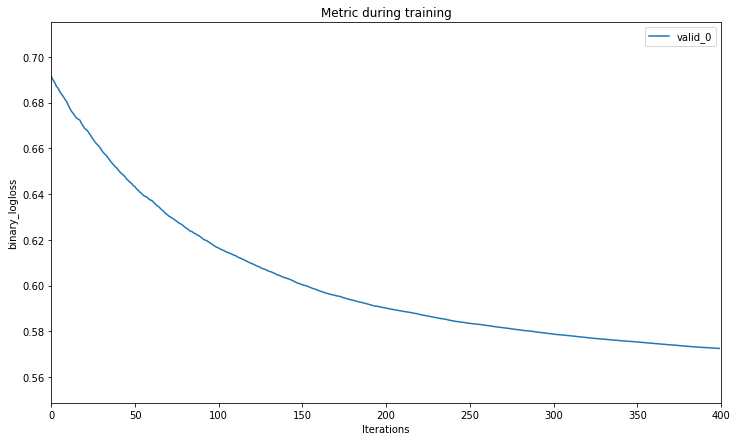

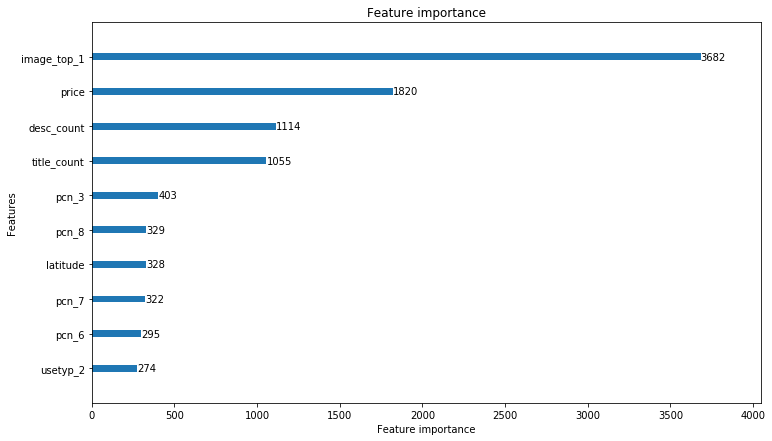

Training logloss: 0.5761144034908576
Training accuracy: 0.6830022668255927


In [15]:
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['num_leaves'] = 30
params['feature_fraction'] = .6
params['bagging_fraction'] = .8

n_boost = 400
v_num = n_boost/10

# Create train, val, test splits
xtrain, xval, ytrain, yval = train_test_split(up_train, up_labels, test_size=0.2, random_state=0)
# Format for LightGBM training
d_train = lgb.Dataset(xtrain, label=ytrain)
d_val = lgb.Dataset(xval, label=yval)

# Train model
evals_result = {}  # Record results for plotting
lgbm = lgb.train(params, d_train, num_boost_round=n_boost, valid_sets=[d_val], evals_result=evals_result, 
                 verbose_eval=v_num)

# Get predictions
trainpred = lgbm.predict(train)
testpred = lgbm.predict(test)

# Make plots
ax = lgb.plot_metric(evals_result, metric=params['metric'], figsize=(12, 7), grid=False)
plt.show()
ax = lgb.plot_importance(lgbm, max_num_features=10, figsize=(12, 7), grid=False)
plt.show()

print 'Training logloss:', log_loss(y_pred=trainpred, y_true=bin_labels)
print 'Training accuracy:', accuracy_score(y_pred=np.rint(trainpred), y_true=bin_labels)

## Make Dataset Splits Based on Prediction:

In [16]:
cls_results_train = np.rint(trainpred)
cls_results_test = np.rint(testpred)

In [17]:
below_train_idx = np.where(cls_results_train == 1)[0]
above_train_idx = np.where(cls_results_train == 0)[0]

below_test_idx = np.where(cls_results_test == 1)[0]
above_test_idx = np.where(cls_results_test == 0)[0]

In [18]:
above_train = train.iloc[above_train_idx]
above_label = label_csv[above_train_idx]
above_test = test.iloc[above_test_idx]

below_train = train.iloc[below_train_idx]
below_label = label_csv[below_train_idx]
below_test = test.iloc[below_test_idx]

## Regressors:

In [19]:
train_pred = np.zeros(train.shape[0])
test_pred = np.zeros(test.shape[0])

### Above Regressor:

Start training on stageabove
[50]	valid_0's rmse: 0.319766
[100]	valid_0's rmse: 0.316366
[150]	valid_0's rmse: 0.313849
[200]	valid_0's rmse: 0.311704
[250]	valid_0's rmse: 0.310152
[300]	valid_0's rmse: 0.308896
[350]	valid_0's rmse: 0.307878
[400]	valid_0's rmse: 0.306963
[450]	valid_0's rmse: 0.306206
[500]	valid_0's rmse: 0.305613


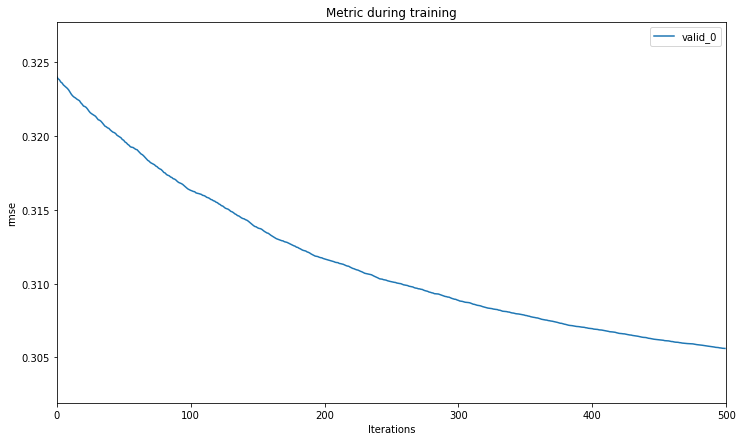

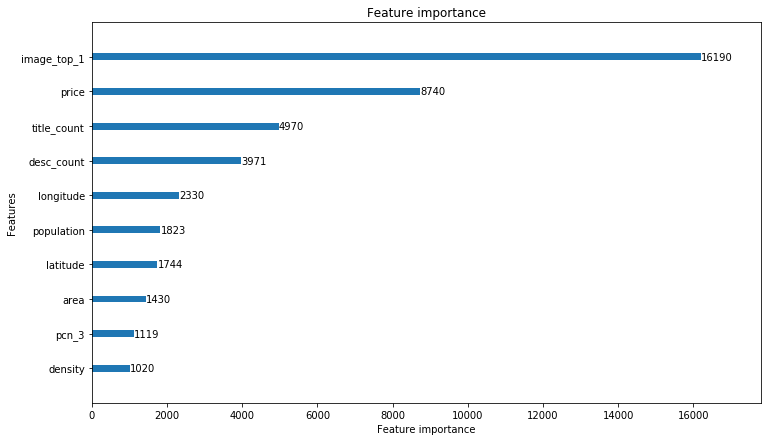

Training error: 0.30494504600490363


In [20]:
i = 'above'
stage_name = 'stage%s'%i

# Parameters
params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['num_leaves'] = 100
params['feature_fraction'] = .6
params['bagging_fraction'] = .8
n_boost = 500
v_num = n_boost/10

trainpred, testpred = run_training(stage_name, params, n_boost, v_num, above_train, above_label, above_test)
# Evalulate training error
print 'Training error:', np.sqrt(mean_squared_error(y_pred=trainpred, y_true=above_label))

# Append to training and test predictions
train_pred[above_train_idx] = trainpred
test_pred[above_test_idx] = testpred

### Below Regressor:

Start training on stagebelow
[50]	valid_0's rmse: 0.17952
[100]	valid_0's rmse: 0.178671
[150]	valid_0's rmse: 0.178054
[200]	valid_0's rmse: 0.177578
[250]	valid_0's rmse: 0.177224
[300]	valid_0's rmse: 0.176952
[350]	valid_0's rmse: 0.176747
[400]	valid_0's rmse: 0.176571
[450]	valid_0's rmse: 0.176419
[500]	valid_0's rmse: 0.176301


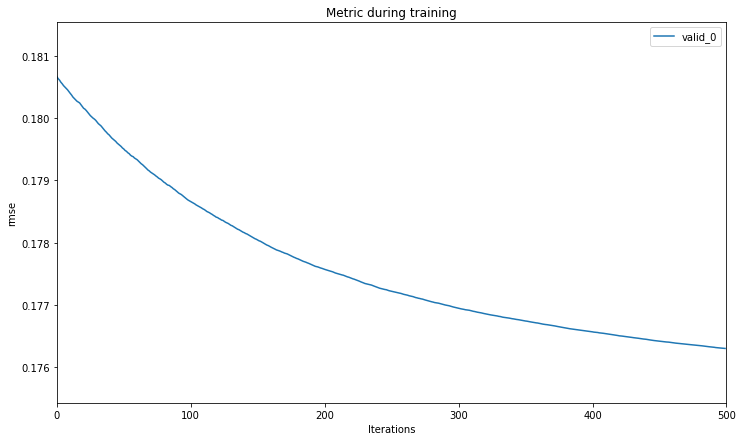

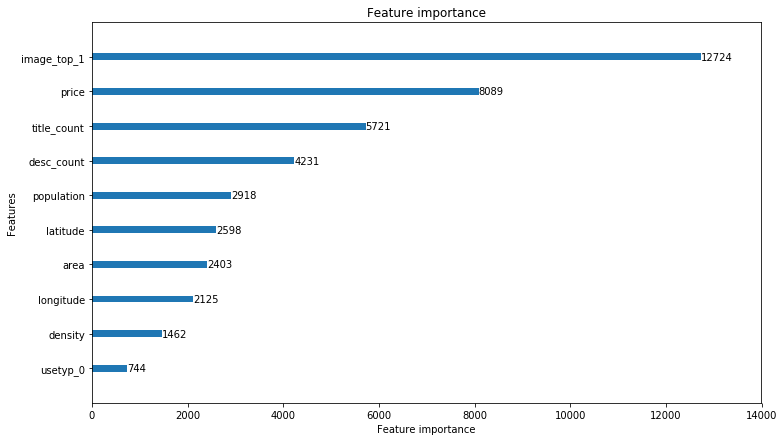

Training error: 0.17582444938917527


In [21]:
i = 'below'
stage_name = 'stage%s'%i

# Parameters
params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['num_leaves'] = 100
params['feature_fraction'] = .6
params['bagging_fraction'] = .8
n_boost = 500
v_num = n_boost/10

trainpred, testpred = run_training(stage_name, params, n_boost, v_num, below_train, below_label, below_test)
# Evalulate training error
print 'Training error:', np.sqrt(mean_squared_error(y_pred=trainpred, y_true=below_label))

# Append to training and test predictions
train_pred[below_train_idx] = trainpred
test_pred[below_test_idx] = testpred

### Evaluate Overall Training Error:

In [22]:
print 'Overall training error:', np.sqrt(mean_squared_error(y_pred=train_pred, y_true=label_csv))

Overall training error: 0.23258352719526185


### Explore Errors:

In [23]:
eval_df = pd.concat((train, pd.Series(label_csv, name='deal_prob'), pd.Series(train_pred, name='pred')), axis=1)
eval_df['error'] = np.around(np.square(np.subtract(eval_df.deal_prob, eval_df.pred)), decimals=4)

In [24]:
# Error statistics
eval_df.error.describe()

count    1.503424e+06
mean     5.409502e-02
std      1.136894e-01
min      0.000000e+00
25%      2.600000e-03
50%      7.300000e-03
75%      3.980000e-02
max      7.609000e-01
Name: error, dtype: float64

In [25]:
err_thresh = eval_df.error.mean() + eval_df.error.std()

above_eval = eval_df.loc[(eval_df.error >= err_thresh)]
below_eval = eval_df.loc[(eval_df.error < err_thresh)]

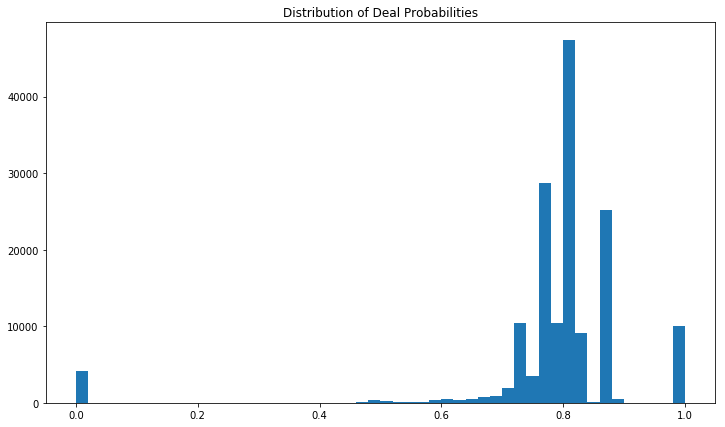

In [26]:
above_eval.deal_prob.hist(bins=50, figsize=(12, 7), grid=False)
# below_eval.deal_prob.hist(bins=50, figsize=(12, 7), grid=False)
plt.title('Distribution of Deal Probabilities')
plt.show()

## Make Submission:

In [27]:
# Make submission script
with open(test_items_path, 'rb') as handle:
    test_item_id = pickle.load(handle)
make_submission(test_pred, test_item_id, submission_path)